In [ ]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 224041421 / HD 173928 / WDS J18488-1836AB / Gaia DR3 4098425954745263104  Analysis (EA)

- some uncertainty in ID, the target is a known visual double star (separation 0.4" per WDS).
  - The 2 stars are not resolved by Gaia DR3 either
- new VSX entry


## TESS Data

In [2]:
tic = 224041421

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
# sr = sr[sr.author == "QLP"]  # for uniformity, only 1 sector (3) has no QLP data
# sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 92,2025,SPOC,120,224041421,0.0,N/A


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 224041421" SECTOR=92 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [ ]:
lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=1, alpha=0.9);
axs[0].get_figure().suptitle(f"Contaminant {lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
[ax.set_ylim(0.9985, 1.001) for ax in axs];

Note: TESS TCEs identify the eclipses.
https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2025127110927-s0092-s0092-0000000224041421-01014_dvm.pdf

The TCE centorid is not reliable as the pixels near the target are saturated or near saturated. Per-pixel plot suggests the eclipses are on target.

## Gaia DR3 info (coordinate, etc.)

In [4]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext.py:1958: UserWarning: gaia_dr3_mag_to_vmag(): b_minus_r value (--) is outside the applicable range for the transformation. The result is probably not reliable.
  warnings.warn(


flag,_r,_p,Source,RPmag,Gmag,BPmag,BP-RP,Vmag,Teff,RUWE,sepsi,epsi,NSS,Plx,pmRA,pmDE,VarFlag,RV,e_RV,IPDfmp,Dup,RAJ2000,DEJ2000,EpochPh,EpochRV
,arcsec,deg,,mag,mag,mag,mag,mag,K,,,mas,,mas,mas / yr,mas / yr,,km / s,km / s,,,deg,deg,,
str4,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,str48,float64,float64,float64,str34,float64,float32,int16,uint8,float64,float64,uint8,uint8
!! ✓,0.000,0.0,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=4098425954745263104&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET'>4098425954745263104,5.453,6.397,6.660,1.207,6.696,5819.2,2.302,106,0.405,0,3.4000,2.990,-1.312,NOT_AVAILABLE,-31.91,0.13,98,0,282.18922114884,-18.60115749840,0,0
!,7.311,186.1,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=4098425954704434048&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET'>4098425954704434048,15.148,19.259,16.745,1.597,19.755,--,--,2.64,1.974,0,--,--,--,NOT_AVAILABLE,--,--,0,0,282.18900905659,-18.60318282333,0,0
!,8.099,150.5,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I

The target is also listed as an astrometric binary with 177.74 d (+/- 1.33 d) period in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65a1a2351812e4&-source=I%2F357&Source=5483610730803645312)


In [6]:
primary_name = f"TIC {tic}"
primary_name

'TIC 224041421'

## Combining all data


TESS # data points: 16958
Masking out distorted cadence near a momentum dump
TESS # data points: 16923


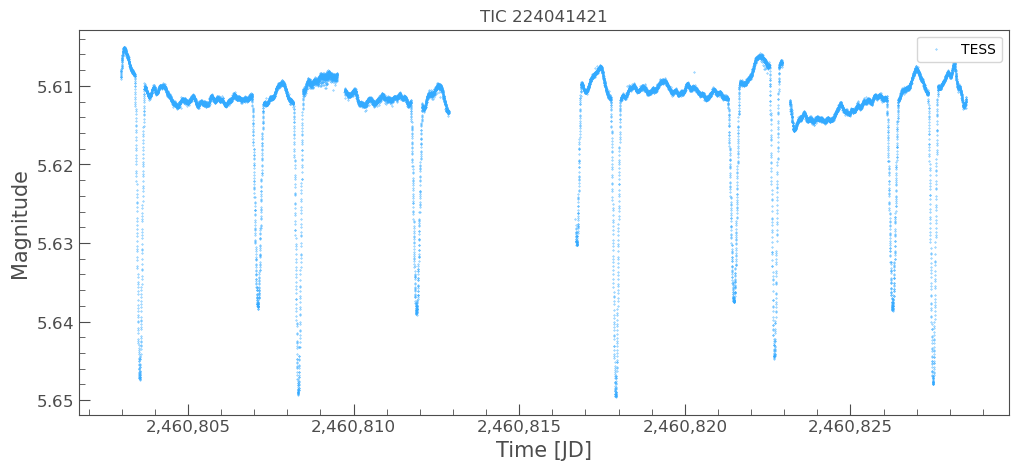

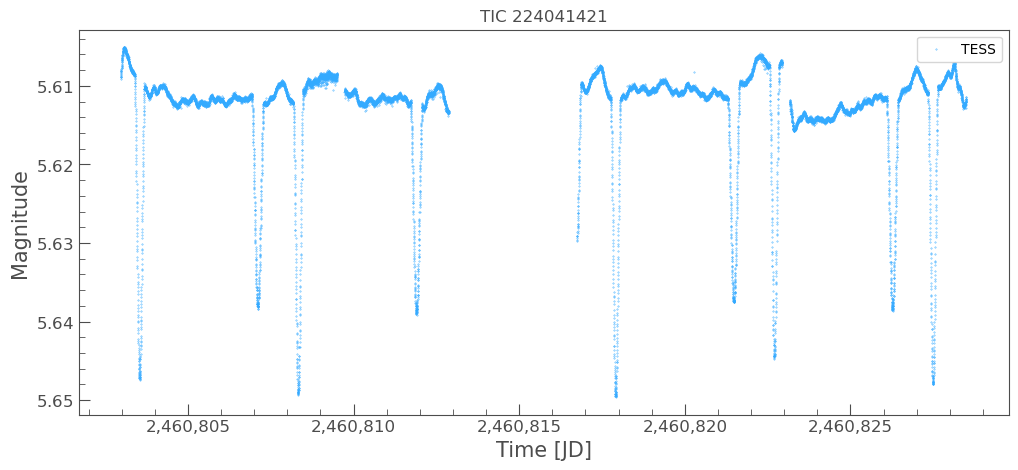

In [23]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
    }, 
    shift_to=None,
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
# plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0

# in PDCSAP_FLUX, the data near a momentum dump is distorted, affecting the dips
print("Masking out distorted cadence near a momentum dump")

lc_tess = lke.exclude_range(lc_tess, 2460816.65, 2460816.75)  
lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
    }, 
    shift_to=None,
)
for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))
ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);


## Final epoch / period / duration


Adopted period / epoch / duration_hr:  4.791 2460803.54 7.0 8.0
Min II phase: -0.255


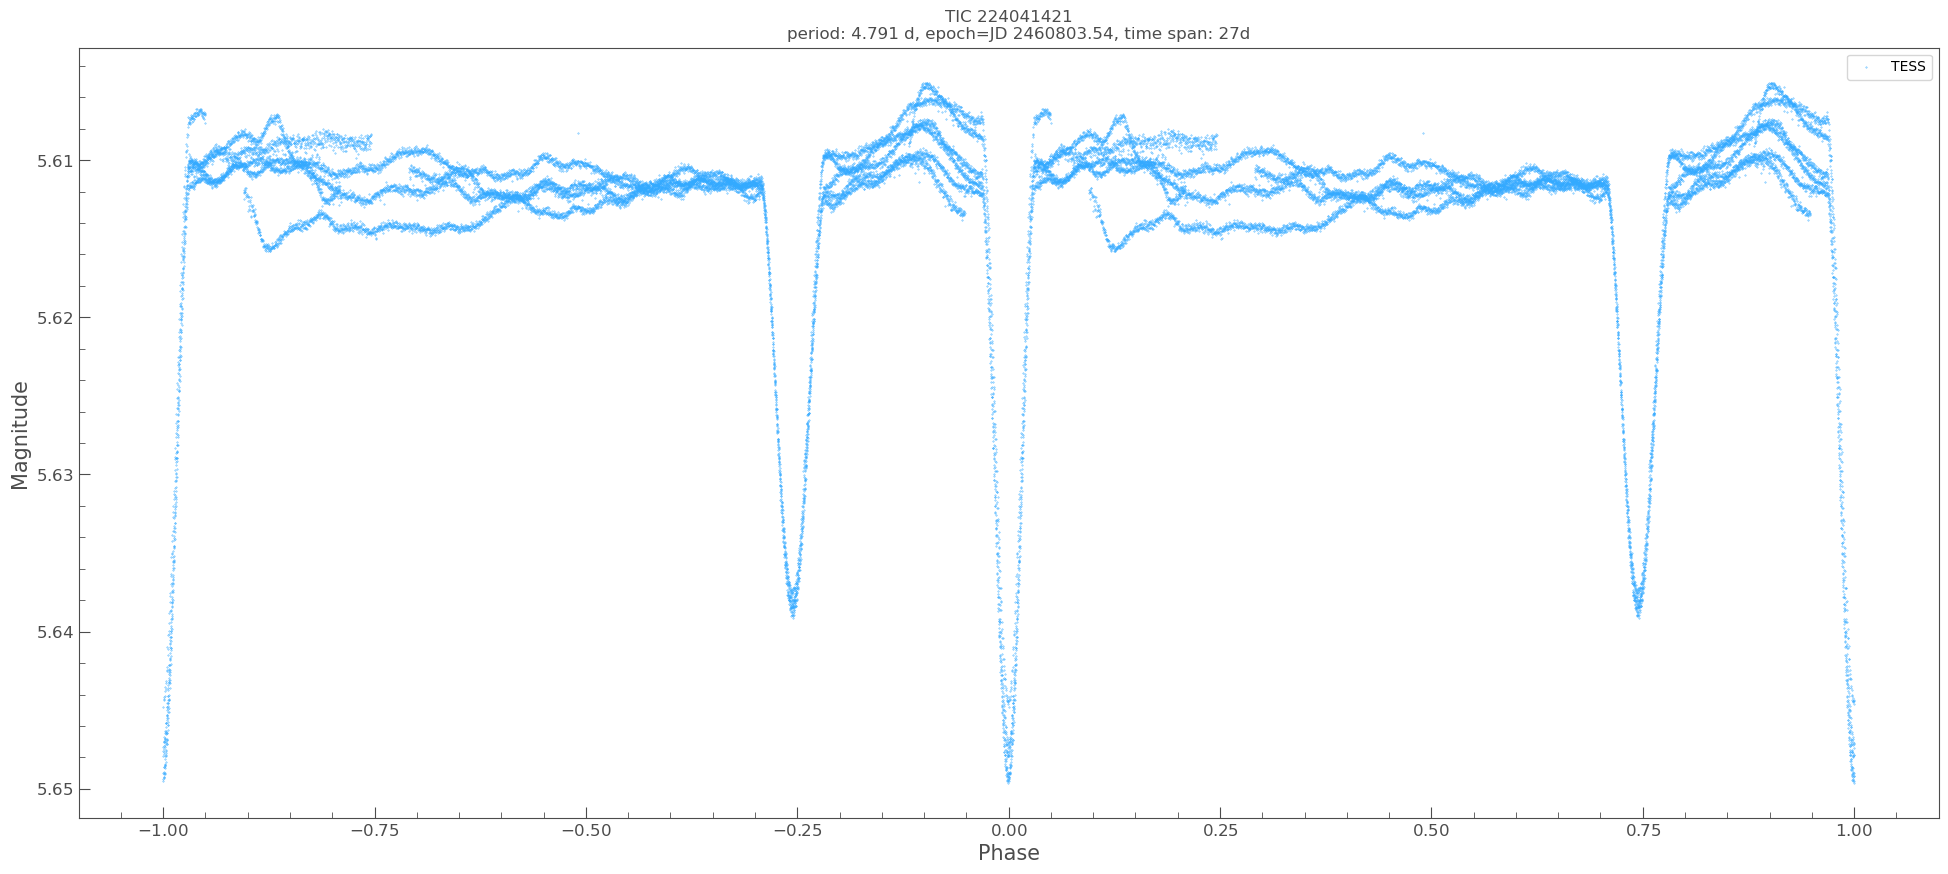

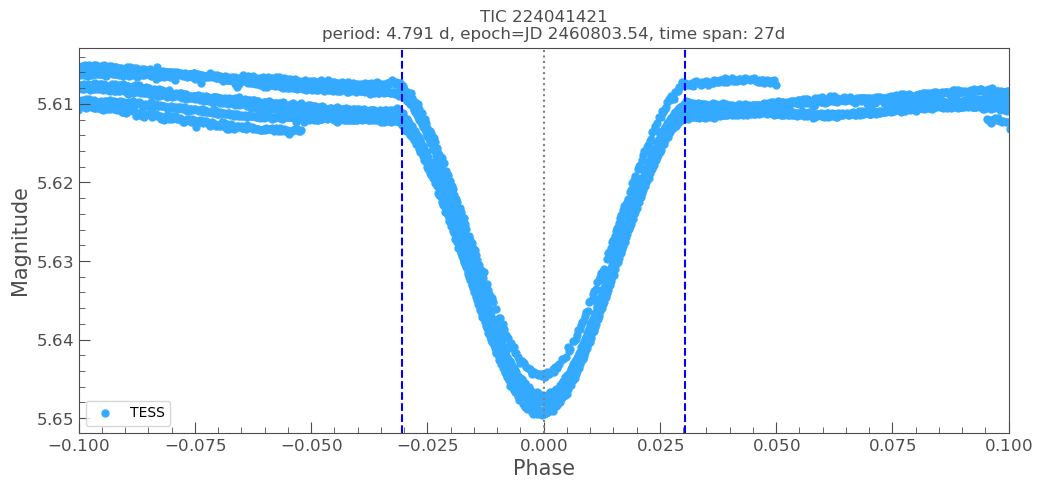

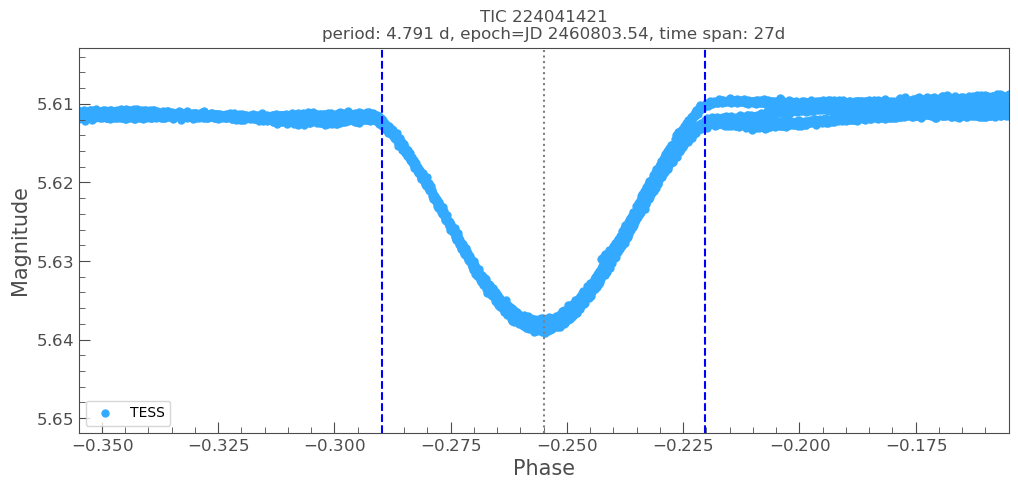

In [43]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = 4.791  # TCE1 4.79062 [0.0001], TCE2: 4.79069 [0.00021]
epoch_time_btjd_final = 3803.54  # TCE1
epoch_time_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_btjd_final, target_coord), 2)  
epoch_time_min_ii_btjd_final = 3807.11   #  TCE2
epoch_time_min_ii_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_min_ii_btjd_final, target_coord), 2) 

duration_hr_min_i_final = 7.0
duration_hr_min_ii_final = 8.0

# Note: slightly eccentric
epoch_phase_min_ii_final   = abs(epoch_time_min_ii_btjd_final   - epoch_time_btjd_final  ) / period_final   % 1
if epoch_phase_min_ii_final   > 0.5:
    epoch_phase_min_ii_final   = epoch_phase_min_ii_final   - 1
epoch_phase_min_ii_final  = round(epoch_phase_min_ii_final  , 3)  # precsion from eyeballing zoomed plot

print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final, duration_hr_min_ii_final)
print("Min II phase:", epoch_phase_min_ii_final)

# --- Plot them to verify ---

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    # {"TESS": lcc_tess[-1].select_flux("sap_flux").normalize() }, 
    period=period_final,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    # plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(12, 5),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(epoch_phase_min_ii_final, c="gray", linestyle="dotted");
ax.set_xlim(epoch_phase_min_ii_final  -0.1, epoch_phase_min_ii_final  +0.1);  # to see Min II in details


## Determine Magnitude Range


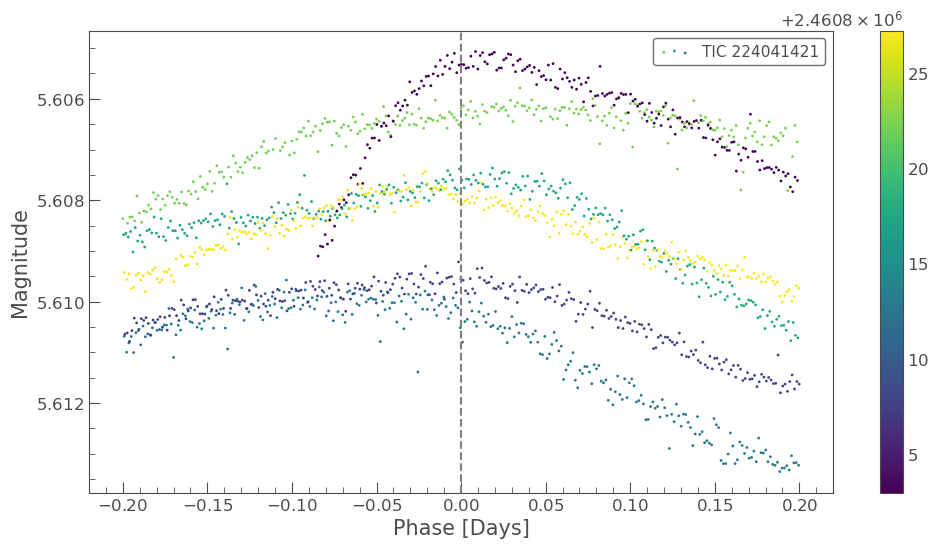

In [53]:
# zoom around max
lc = lc_combined_dict["TESS"]
# max is roughly at +4.33 d
lc_f = lc.fold(epoch_time=epoch_time_hjd_final + 4.31, period=period_final)  
lc_f_trunc = lc_f.truncate(-0.2, 0.2)
ax = tplt.lk_ax(figsize=(12, 6))
ax = tplt.scatter(lc_f_trunc , ax=ax, c=lc_f_trunc.time_original.value, s=4, alpha=1.0);
ax.axvline(0, color="gray", linestyle="--");


In [54]:
# determine max
lc = lc_combined_dict["TESS"]
for max_offset in [4.25, 4.26, 4.27, 4.28, 4.30, 4.31, 4.32, 4.33, 4.34, 4.35, 4.36, 4.37]:
    lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + max_offset, period=period_final).truncate(0 - 2 /24/60, 0 + 2 /24/ 60)
    # print("Max mag # num data points:", len(lc_zoom_max))
    max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
    print(max_offset, round(float(max_flux_mag), 4), len(lc_zoom_max))


4.25 5.6078 12
4.26 5.6081 12
4.27 5.608 12
4.28 5.6078 12
4.3 5.6077 12
4.31 5.6077 12
4.32 5.6077 12
4.33 5.6078 12
4.34 5.608 12
4.35 5.6081 12
4.36 5.6081 12
4.37 5.608 12


Max mag # num data points: 30
Min I mag # num data points: 29
Min II mag # num data points: 20
['5.6078', '5.6114', '5.6478', '5.6383']
(0.04, 0.036, 0.027)


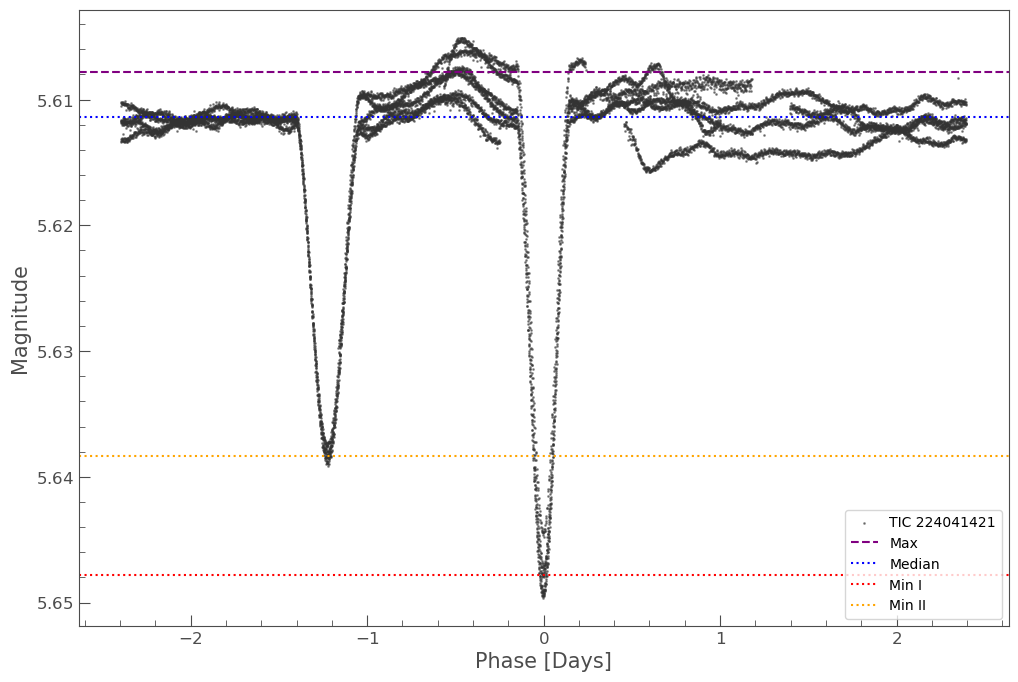

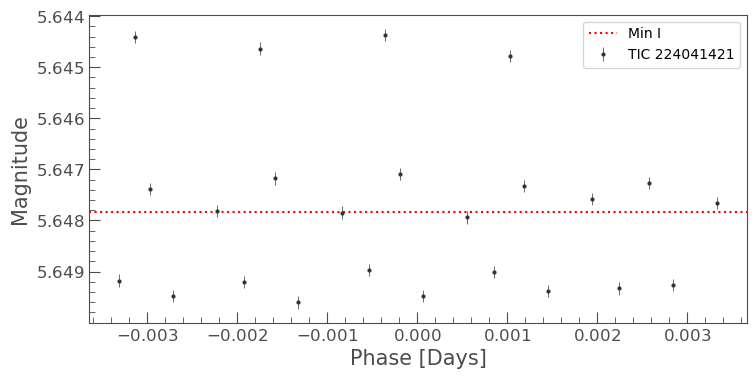

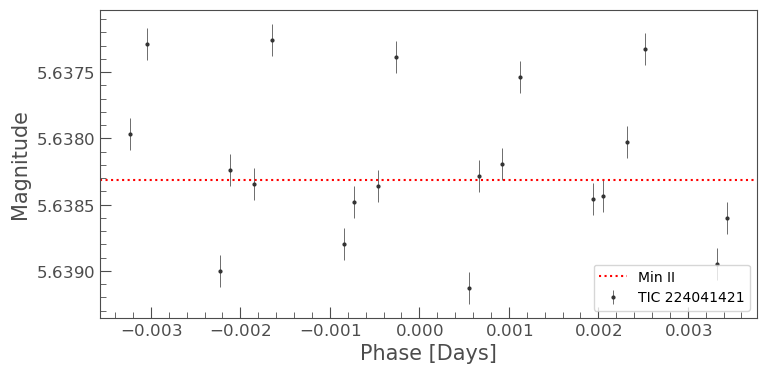

In [61]:
# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + 4.31, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)


lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd_final, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Min II mag # num data points:", len(lc_zoom_min_ii))
min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)



lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ax.set_ylim(*ylim);

ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

ax = tplt.errorbar(lc_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [max_flux_mag, median_flux_mag, min_flux_mag, min_ii_flux_mag]])


# ampitude in TESS
amp_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)) , 3)  # in TESS band, probably don't have 4 digit precison

amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 3)  

amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 3)  

print((amp_flux_mag, amp_min_i_flux_mag, amp_min_ii_flux_mag))


## Plots for VSX

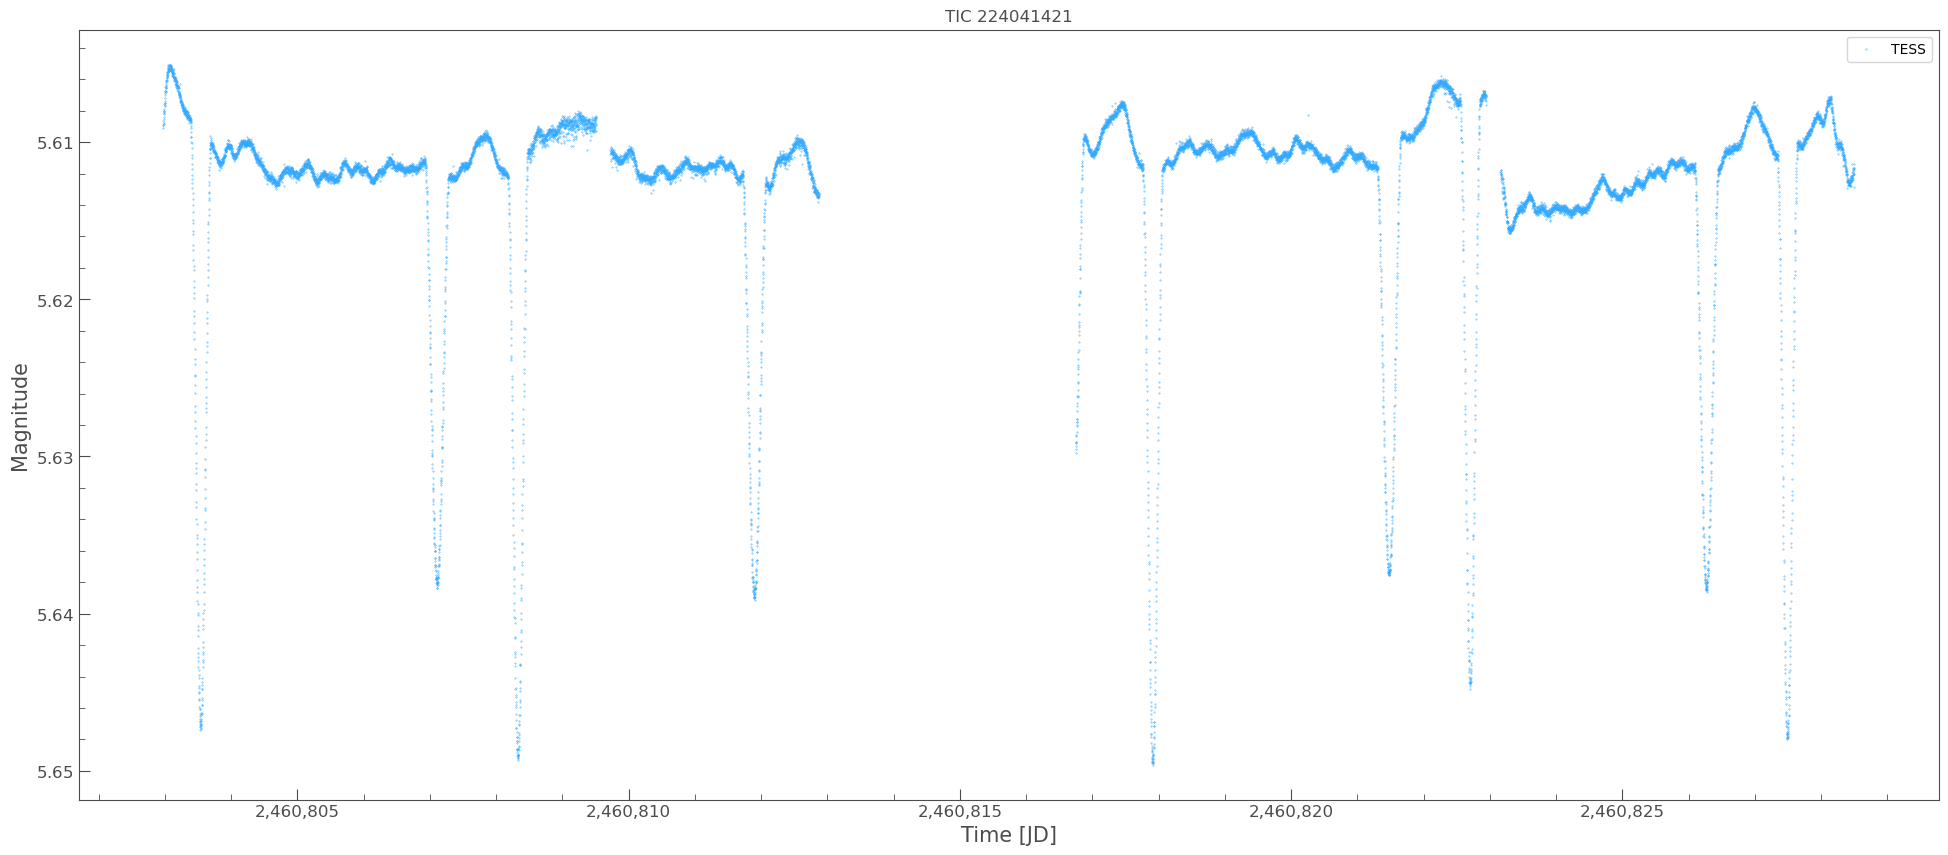

In [62]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
ax.set_title(ax.get_title());

#### Phase Plot



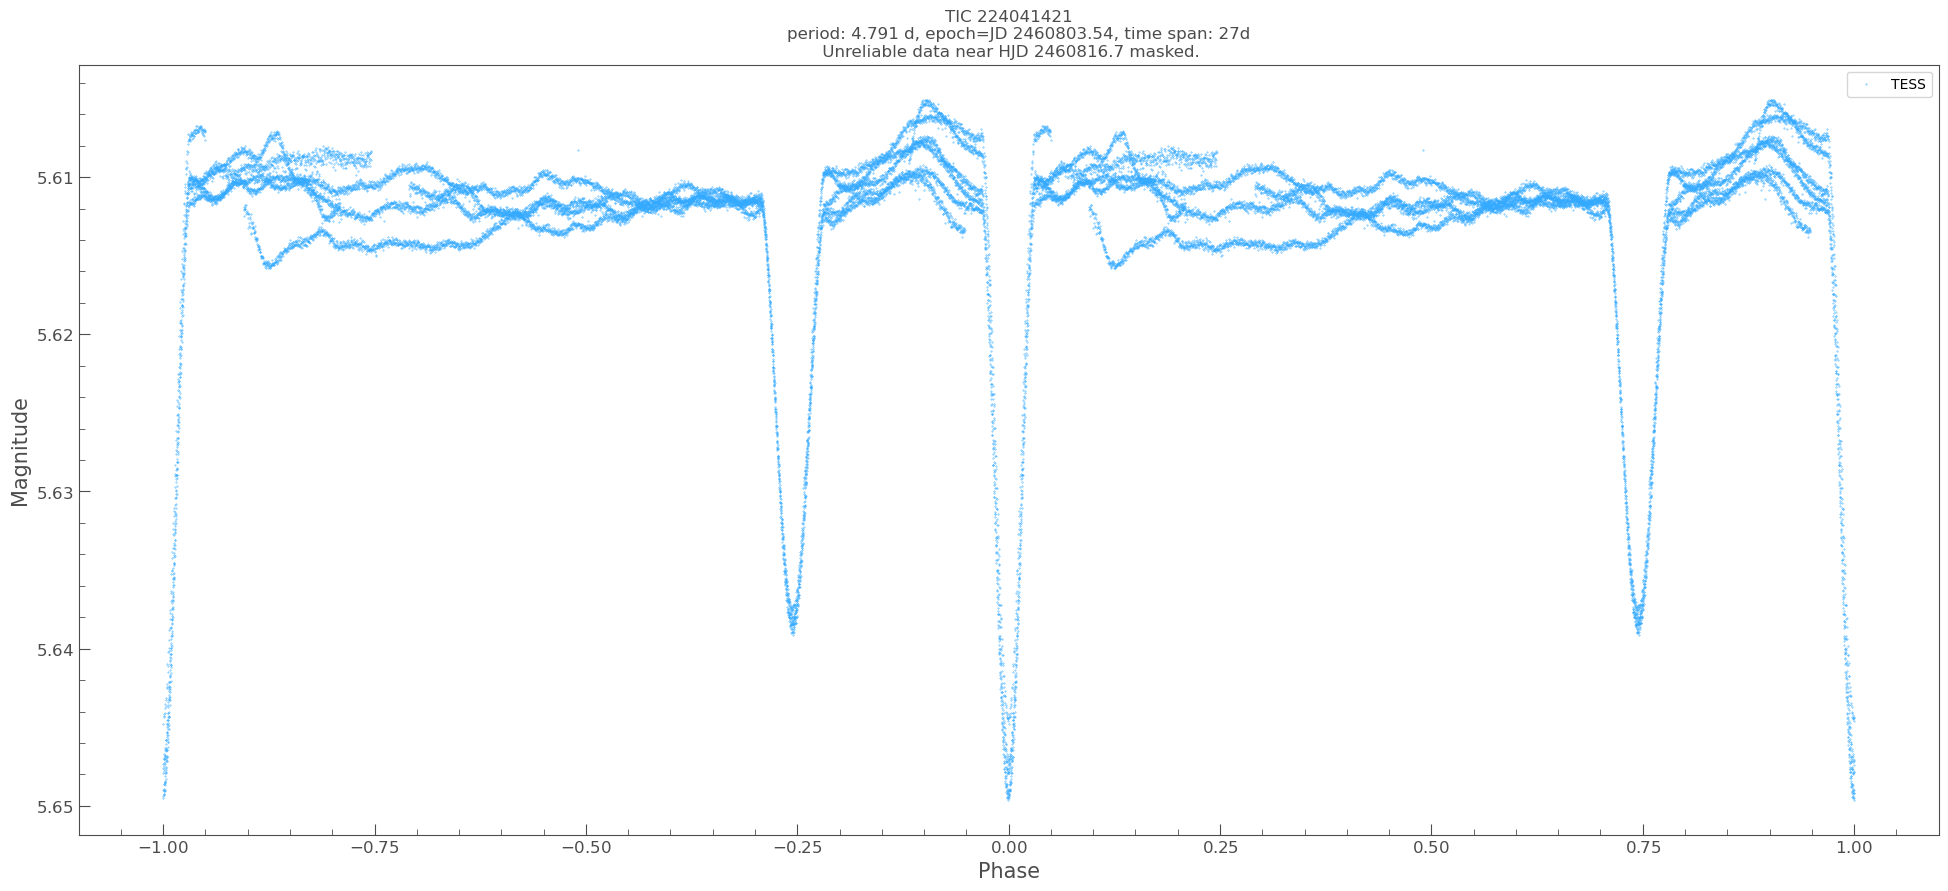

In [63]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 3  # default 2
# plot_options[0][1]["s"] = 4
# plot_options[1][1]["markersize"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\n Unreliable data near HJD 2460816.7 masked.");


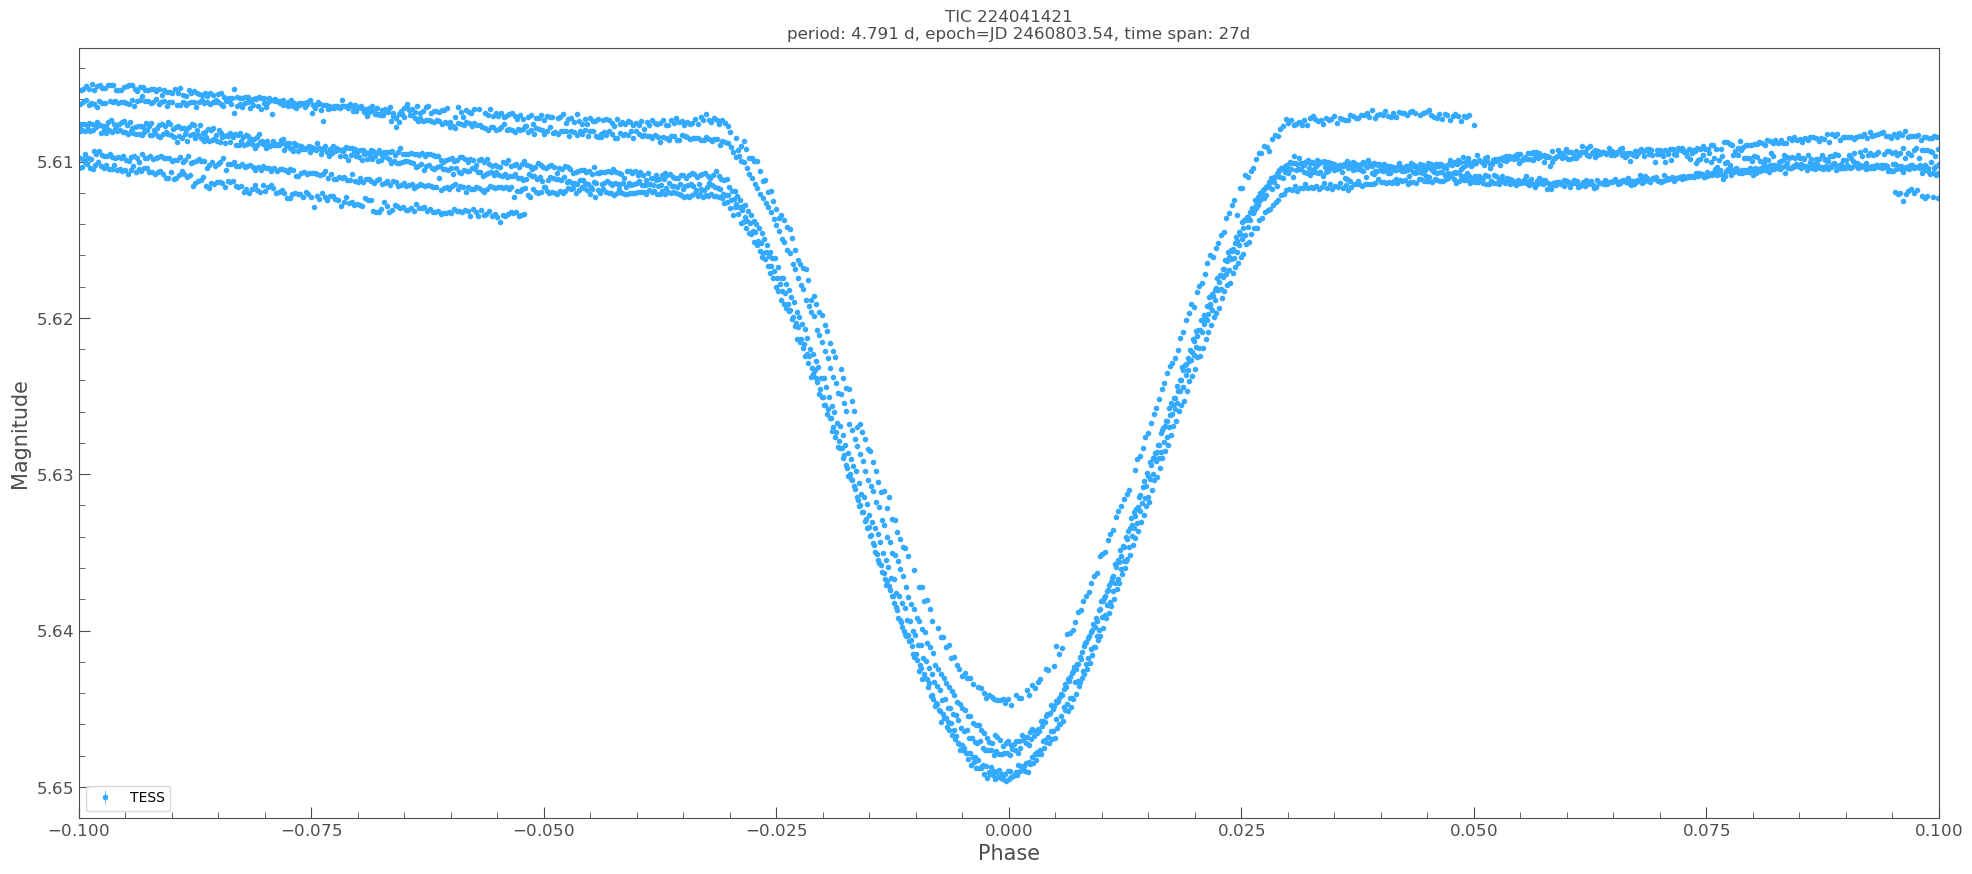

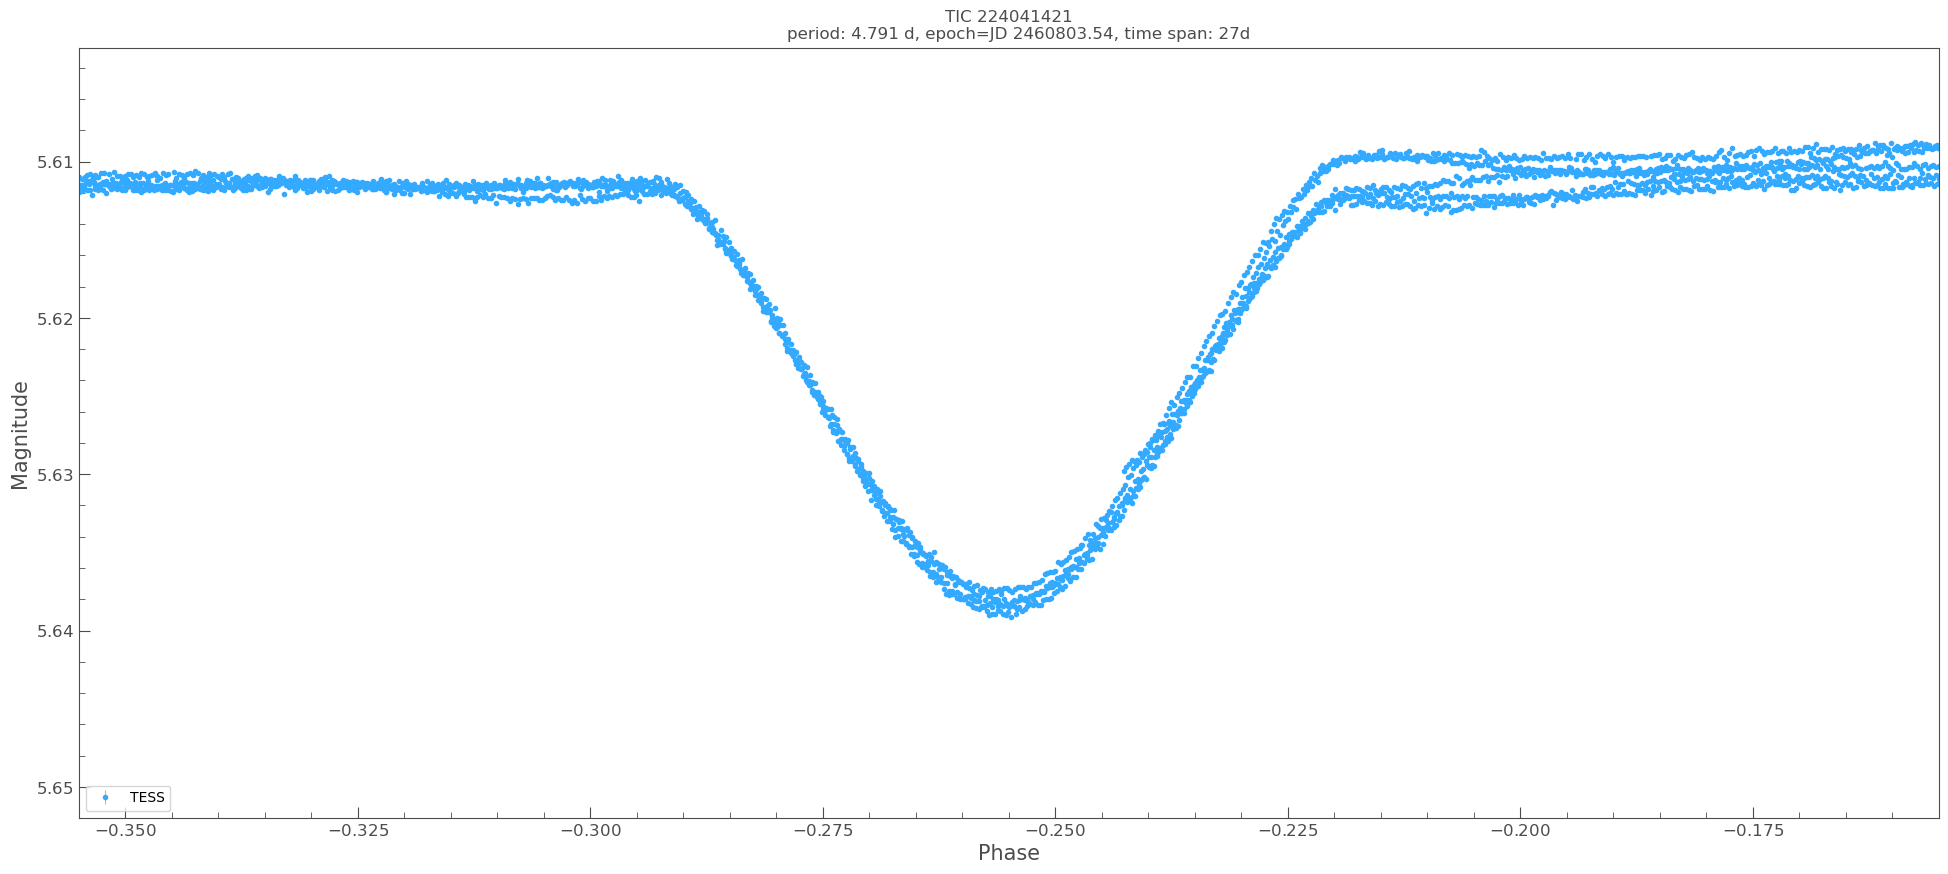

In [64]:

# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
# plot_options_zoom[0][1]["s"] = 25  # larger dots
plot_options_zoom[0] = ('errorbar', {'marker': '.', 'c': '#3AF', 'linewidth': 0.5, 'ls': 'none'})  # use error bar

# to workaround astropy TypeError: cannot write to unmasked output when doing matplotlib errorbar  plot
_lc = lc_combined_dict['TESS'].copy()
_lc.flux_err = _lc.flux_err.filled(np.nan)

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(24, 10),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.set_xlim(epoch_phase_min_ii_final  -0.1, epoch_phase_min_ii_final  +0.1);  # to see Min II in details


## VSX Report Table

In [65]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [87]:
import bibs_utils
# reload(bibs_utils)

# TIC are not added, given the entry refers to thw whole system per SO
other_names = f"HIP 92301,2MASS J18484541-1836041,UCAC4 357-163490"  # ExoFOP  and  SIMBAD
other_names += ",HD 173928,WDS J18488-1836,GSC 06285-00193"  # Useful IDs from SIMBAD, 
other_names += ",SAO 161848"  # bright stars, add IDs for other well known catalogs on SIMBAD. No GJ, CD, CPD names

remarks = (
    f"""Eccentric system. Min I amplitude {amp_min_i_flux_mag} TESS. Min II at phase {vsx_phase(epoch_phase_min_ii_final)}, amplitude {amp_min_ii_flux_mag} TESS, duration {100 * duration_hr_min_ii_final / 24 / period_final:.1f}% . """
    f"""Given amplitudes are all minimum amplitudes because the CCD pixels are saturated at the target position in TESS data. """
    f"""Uncertain identification: the target is a known double star. Per WDS, A has V = 6.87 .  B has V = 8.14 and was 0.4" to SE in 2021. The position given is the position of the composite AB from Gaia DR3. """
)

revision_comment = "Type, period, epoch, eclipse duration and amplitudes from TESS data. Mean magnitude from 1995yCat.2167....0H . Position from Gaia DR3. Spectral type from 1988mcts.book.....H ."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="A1V+K1III",  # from 1988mcts.book.....H, by way of SIMBAD
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"6.46",  #  (a bright star, use native V values from GCPD) --  https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ686eee352cfb71&-out.add=.&-source=II/167/catalog&recno=82628
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f">{amp_flux_mag:}",   # in TESS from the plot above
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,
    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",  
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.1f}", 
    Discoverer="Sam Lee", 
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference2_Name=BIBS.GAIA_DR3_N,  # for position
    Reference2_Bib=BIBS.GAIA_DR3_B,  
    Reference4_Name="Hauck, B.; et al., 1990, General Catalogue of Photometric Data",  # for mean V mag
    Reference4_Bib="1995yCat.2167....0H",
    Reference5_Name="Houk, N.; Smith-Moore, M., 1988, Michigan Catalogue of Two-dimensional Spectral Types for the HD Stars. Volume 4, Declinations -26°.0 to -12°.0.",  # spectral type
    Reference5_Bib="1988mcts.book.....H",
    Reference6_Name="Mason, B. D.; et al., 2025, The Washington Visual Double Star Catalog (Mason+ 2001-2020)",
    Reference6_Bib="2025yCat....102026M",
)


def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic224041421_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
print("""
tic224041421_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS SPOC PDCSAP_FLUX. Data near HJD 2460816.7 masked as they are distorted (associated with a TESS momentum dump).
""")


Other Names (1 line each):
HIP 92301
2MASS J18484541-1836041
UCAC4 357-163490
HD 173928
WDS J18488-1836
GSC 06285-00193
SAO 161848

Eccentric system. Min I amplitude 0.036 TESS. Min II at phase 0.745, amplitude 0.027 TESS, duration 7.0% . Given amplitudes are all minimum amplitudes because the CCD pixels are saturated at the target position in TESS data. Uncertain identification: the target is a known double star. Per WDS, A has V = 6.87 .  B has V = 8.14 and was 0.4" to SE in 2021. The position given is the position of the composite AB from Gaia DR3. 

Type, period, epoch, eclipse duration and amplitudes from TESS data. Mean magnitude from 1995yCat.2167....0H . Position from Gaia DR3. Spectral type from 1988mcts.book.....H .


,Field,Value
0,Position,"282.18922114884, -18.6011574984"
1,Primary_Name,TIC 224041421
2,Other_Names,"HIP 92301,2MASS J18484541-1836041,UCAC4 357-163490,HD 173928,WDS J18488-1836,GSC 06285-00193,SAO 161848"
3,Variable_Type,EA
4,Spectral_Type,A1V+K1III
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,6.46
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,>0.04
9,Minimum_Magnitude_band,TESS



tic224041421_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS SPOC PDCSAP_FLUX. Data near HJD 2460816.7 masked as they are distorted (associated with a TESS momentum dump).

